In [1]:
from sklearn import datasets, tree, metrics, ensemble
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
from sklearn.model_selection import train_test_split
import pandas as pd
import statistics
import einops
from keras.datasets import mnist
from keras.utils import np_utils

In [2]:
time_multiplicator = 1
seed = 244810
samples = 2410

In [3]:
def vis(net,out, name):
    fig, axs = plt.subplots(2, 2,figsize=(14,14))

    mycmap = "coolwarm"
    minv = np.min(X_train)+np.min(X_train)/10
    maxv = np.max(X_train)+np.max(X_train)/10
    mesh = np.meshgrid(np.arange(minv, maxv, 0.1), np.arange(minv, maxv, 0.1))[0]
    my_predict = np.array(net.predict(np.c_[mesh.ravel(), mesh.T.ravel()])).reshape(mesh.shape)


    # my_predict = np.round(my_predict)
    axs[0,0].contourf(mesh, mesh.T, my_predict, alpha=0.2,cmap=mycmap)
    axs[0,0].contour(mesh, mesh.T, my_predict, alpha=0.2,cmap=mycmap)
    axs[0,0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker="o", alpha=0.5,cmap=mycmap)
    axs[0,0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker="+", alpha=0.2,cmap=mycmap)

    my_cm = metrics.confusion_matrix(y_test, np.round(out).reshape(X_test.shape[0]))
    my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
    my_disp.plot(ax=axs[0,1] ,cmap="plasma")
    # my_disp.im_.colorbar.remove()
    my_disp.ax_.set_ylabel('')


    fpr, tpr, thresholds = metrics.roc_curve(y_test,  np.round(net.predict(X_test)).reshape(X_test.shape[0]))
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
    display.plot(ax=axs[1,0])

    axs[1,1].plot(net.errors)
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_ylabel('Error')


    print(name)
    print(f'Czułość       |{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):9.4f}')
    print(f'Specyficzność |{my_cm[1][1]/(my_cm[0][1]+my_cm[1][1]):9.4f}')
    print(f'Skuteczność   |{metrics.accuracy_score(np.round(out), y_test):9.4f}')
    print(f'BACC          |{(my_cm[1][1]/(my_cm[0][1]+my_cm[1][1])+my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))/2 :9.4f}')

In [4]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def __repr__(self):
        return(f"{self.__class__.__name__}")

In [5]:
class Linear(Layer):
    def __init__(self, input_size, output_size):
        self.weights = 2* np.random.rand(input_size, output_size) -1
        self.bias = 2 * np.random.rand(1, output_size) -1

    def forward(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output
    
    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        error = np.dot(self.input.T, output_error)
        self.weights -= learning_rate * error
        self.bias -= learning_rate * output_error
        return input_error
        

In [6]:
class Activation(Layer):
    def __init__(self):
        self.activation = self.logistic
        self.activation_der = self.logistic_der
        
    def logistic(self, X):
        return  1.0/(1+np.exp(-X))
    
    def logistic_der(self, X):
        return self.logistic(X) * (1-self.logistic(X))
    
    def forward(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backward(self, output_error, learning_rate):
        return self.activation_der(self.input) * output_error

In [60]:
from tqdm import tqdm
from sklearn.utils import shuffle

class Network:
    def __init__(self,batch=8):
        self.batch_size = batch
        self.layers = []
        self.loss = None
        self.loss_prime = None
        self.errors = []
        self.loss = self.mse
        self.loss_der = self.mse_der
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true-y_pred)**2);

    def mse_der(self, y_true, y_pred):
        return 2*(y_pred-y_true)/y_true.size;
    
    def add(self, layer):
        self.layers.append(layer)
        
    def predict(self, input_data):
        samples = len(input_data)
        result = []

        for i in range(samples):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward(output)
            result.append(output)

        return result


    def fit(self, x_train, y_train, epochs, learning_rate):

        samples = x_train.shape[0]
        batch_divisible = samples - (samples % self.batch_size)
        indexes = np.arange(samples)
        
        for i in tqdm(range(epochs)):
            err = 0
            
            x_train, y_train = shuffle(x_train, y_train, random_state=0)
            
            for i in range(int(np.floor(samples/self.batch_size))):
                x_train_new = x_train[0+i*self.batch_size : self.batch_size+i*self.batch_size]
                y_train_new = y_train[0+i*self.batch_size : self.batch_size+i*self.batch_size]
                
                for j in range(self.batch_size):
                    output = x_train_new[j]
                    for layer in self.layers:
                        output = layer.forward(output)

                    err += self.loss(y_train_new[j], output)


                    error = self.loss_der(y_train_new[j], output)
                    for layer in reversed(self.layers):
                        error = layer.backward(error, learning_rate)


            self.errors.append(err / samples)
            
            
            
            


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.49it/s]


Sieć 2-warstwowa, 4 neurony warstwy ukrytej
Czułość       |   0.9918
Specyficzność |   0.9916
Skuteczność   |   0.9917
BACC          |   0.9917


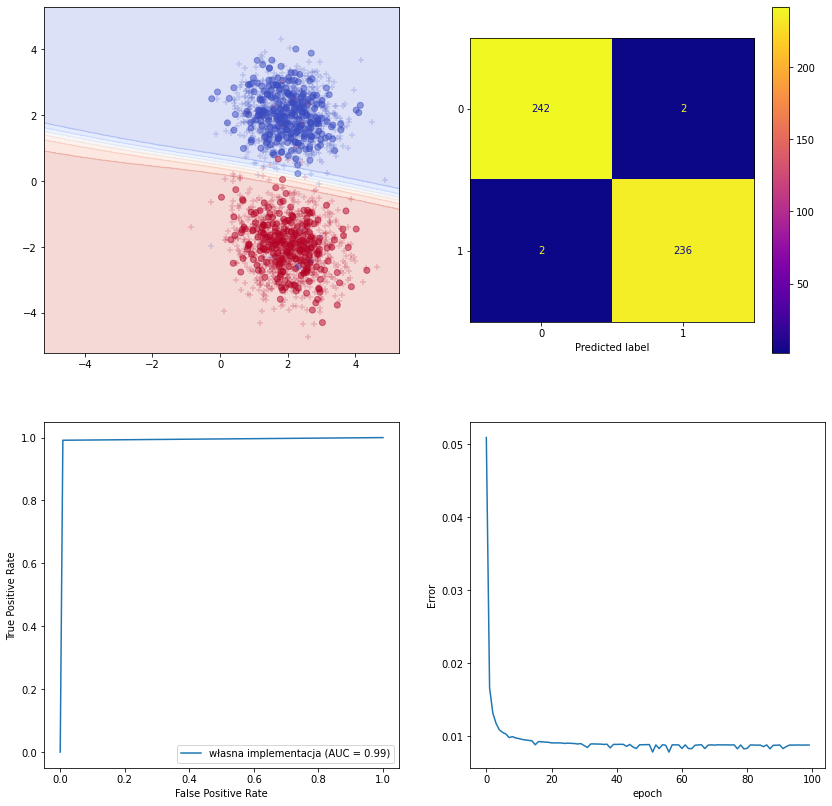

In [61]:
X, y  = datasets.make_classification(n_features=2, n_clusters_per_class=1,n_redundant=0,n_samples=samples, random_state=seed, class_sep=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


net = Network(100)
net.add(Linear(2, 4))
net.add(Activation())
net.add(Linear(4, 1))
net.add(Activation())

X_train_new = X_train.reshape(X_train.shape[0],1,2)

net.fit(X_train_new, y_train, epochs=20, learning_rate=0.05)

out = net.predict(X_test)
out = np.round(out).reshape(X_test.shape[0])


vis(net,out, 'Sieć 2-warstwowa, 4 neurony warstwy ukrytej')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.63it/s]


Sieć 3-warstwowa, 16 neuronów warstw ukrytych
Czułość       |   0.9368
Specyficzność |   0.9869
Skuteczność   |   0.9606
BACC          |   0.9618


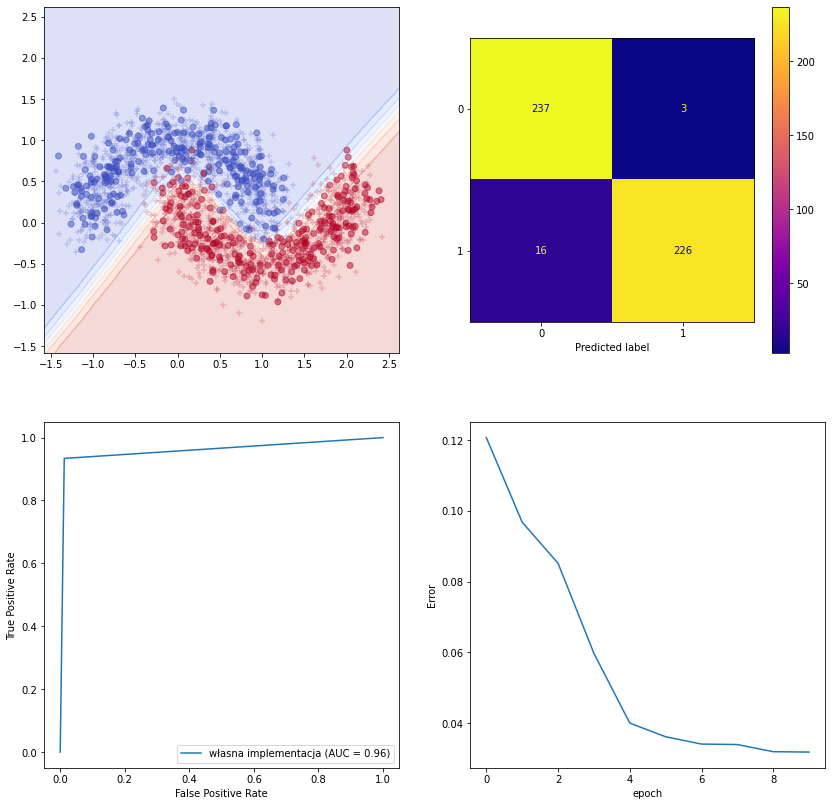

In [62]:
moons, moons_c = datasets.make_moons(n_samples=samples, noise = 0.2, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(moons, moons_c, test_size=0.2, random_state=0)

net = Network(10)
net.add(Linear(2, 16))
net.add(Activation())
net.add(Linear(16, 16))
net.add(Activation())
net.add(Linear(16, 1))
net.add(Activation())

X_train_new = X_train.reshape(X_train.shape[0],1,2)


net.fit(X_train_new, y_train, epochs=10, learning_rate=0.3)

# test
out = net.predict(X_test)
out = np.round(out).reshape(X_test.shape[0])
vis(net,out, 'Sieć 3-warstwowa, 16 neuronów warstw ukrytych')

In [10]:
X_train_new.shape

(1928, 1, 2)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.68it/s]


Sieć 3-warstwowa, 16 neuronów warstw ukrytych
Czułość       |   0.8523
Specyficzność |   0.9312
Skuteczność   |   0.8880
BACC          |   0.8917


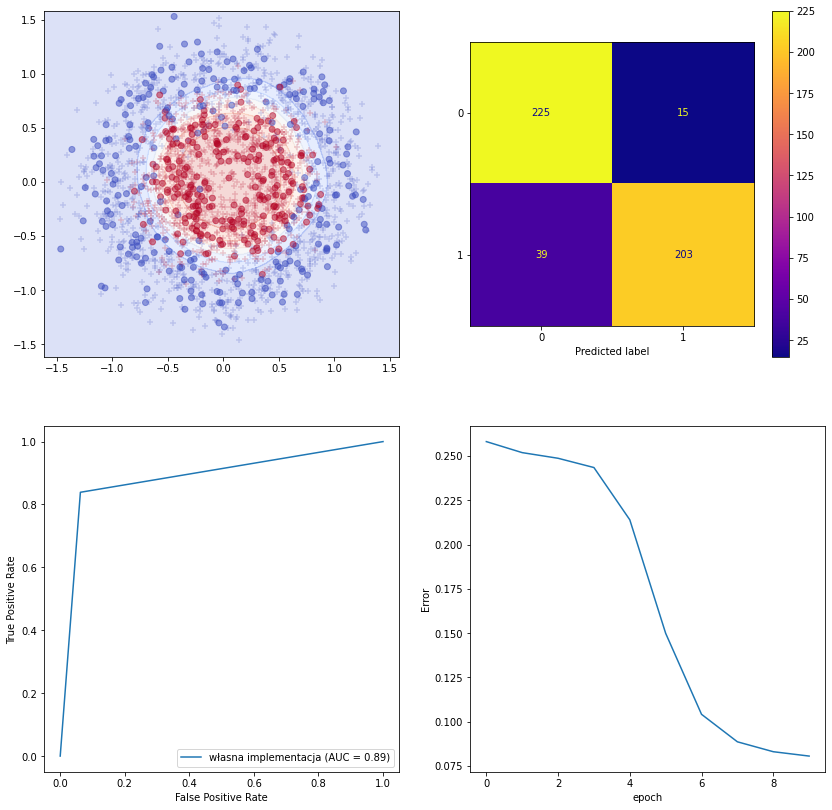

In [63]:
X, y = datasets.make_circles(noise=0.2, factor=0.5, n_samples=samples, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

net = Network(100)
net.add(Linear(2, 16))
net.add(Activation())
net.add(Linear(16, 16))
net.add(Activation())
net.add(Linear(16, 1))
net.add(Activation())

X_train_new = X_train.reshape(X_train.shape[0],1,2)


net.fit(X_train_new, y_train, epochs=10, learning_rate=0.1)

# test
out = net.predict(X_test)
out = np.round(out).reshape(X_test.shape[0])
vis(net,out, 'Sieć 3-warstwowa, 16 neuronów warstw ukrytych')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.55it/s]


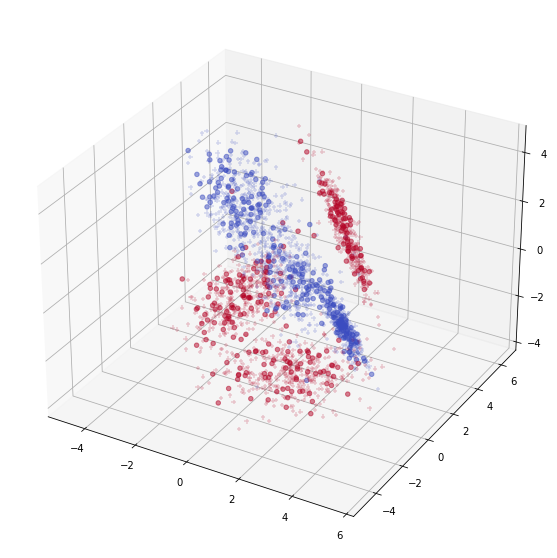

Sieć 3-warstwowa, 16 neuronów warstw ukrytych
Czułość       |   0.9916
Specyficzność |   0.9837
Skuteczność   |   0.9876
BACC          |   0.9876


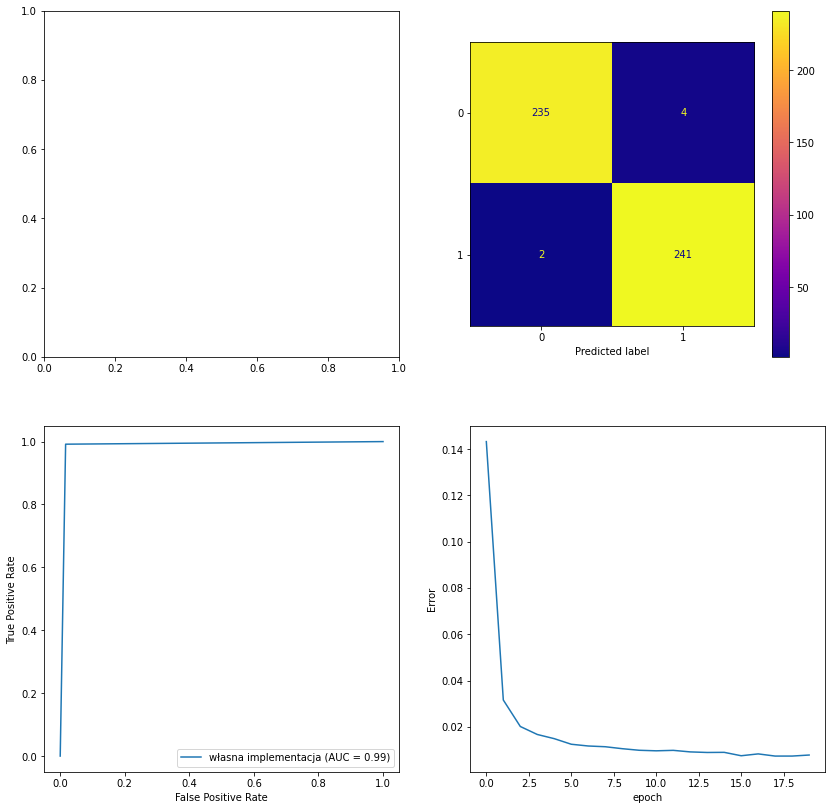

In [64]:
X, y  = datasets.make_classification(n_features=3, n_clusters_per_class=3, n_redundant=0, n_informative=3,n_samples=samples, random_state=seed, class_sep=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

net = Network()
net.add(Linear(3, 16))
net.add(Activation())
net.add(Linear(16, 16))
net.add(Activation())
net.add(Linear(16, 1))
net.add(Activation())

X_train_new = X_train.reshape(X_train.shape[0],1,3)

net.fit(X_train_new, y_train, epochs=20, learning_rate=0.1)

out = net.predict(X_test)
out = np.round(out).reshape(X_test.shape[0])


mycmap = "coolwarm"
plt.rcParams['figure.figsize'] = (10, 10)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1],X_test[:, 2], c=y_test, marker="o", alpha=0.5,cmap=mycmap)
ax.scatter(X_train[:, 0], X_train[:, 1],X_train[:, 2], c=y_train, marker="+", alpha=0.2,cmap=mycmap)
plt.show()

fig, axs = plt.subplots(2, 2,figsize=(14,14))


my_cm = metrics.confusion_matrix(y_test, np.round(out).reshape(X_test.shape[0]))
my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
my_disp.plot(ax=axs[0,1] ,cmap="plasma")
# my_disp.im_.colorbar.remove()
my_disp.ax_.set_ylabel('')


fpr, tpr, thresholds = metrics.roc_curve(y_test,  np.round(net.predict(X_test)).reshape(X_test.shape[0]))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='własna implementacja')
display.plot(ax=axs[1,0])

axs[1,1].plot(net.errors)
axs[1,1].set_xlabel('epoch')
axs[1,1].set_ylabel('Error')


print('Sieć 3-warstwowa, 16 neuronów warstw ukrytych')
print(f'Czułość       |{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):9.4f}')
print(f'Specyficzność |{my_cm[1][1]/(my_cm[0][1]+my_cm[1][1]):9.4f}')
print(f'Skuteczność   |{metrics.accuracy_score(np.round(out), y_test):9.4f}')
print(f'BACC          |{(my_cm[1][1]/(my_cm[0][1]+my_cm[1][1])+my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))/2 :9.4f}')



## MNIST


In [94]:
from keras.datasets import mnist
from keras.utils import np_utils
(X_train, y_train), (X_test, y_test) = mnist.load_data()



In [95]:
X_train_new = X_train.reshape(X_train.shape[0],1,28*28)
X_train_new = X_train_new.astype('float32')
X_train_new /= 255

# kodowanie one hot
y_train = np_utils.to_categorical(y_train)


In [97]:
net = Network(1024)
net.add(Linear(28*28, 100))
net.add(Activation())
net.add(Linear(100, 50))
net.add(Activation())
net.add(Linear(50, 10))
net.add(Activation())


net.fit(X_train_new, y_train, epochs=20, learning_rate=0.05)

# test
X_test_new = X_test.reshape(X_test.shape[0],1,28**2)
X_test_new = X_test_new.astype('float32')
# X_test_new /= 255

out = net.predict(X_test_new)



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [09:42<00:00, 29.11s/it]
C:\Users\Rafal\AppData\Local\Temp\ipykernel_22856\4015996511.py:7: RuntimeWarning: overflow encountered in exp
  return  1.0/(1+np.exp(-X))


In [98]:
ans = []
for v in out:
    ans.append(np.argmax(v))

In [99]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

MNIST
Czułość       |   1.0000
Specyficzność |   1.0000
Skuteczność   |   0.9332
BACC          |   1.0000


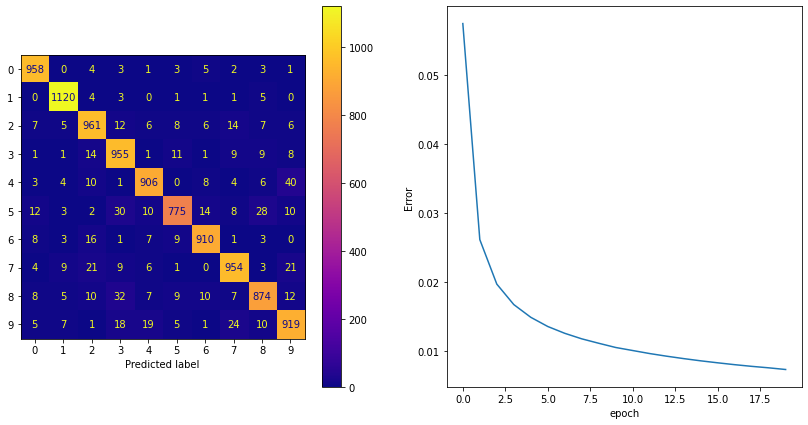

In [101]:
fig, axs = plt.subplots(1, 2,figsize=(14,7))
mycmap = "coolwarm"


my_cm = metrics.confusion_matrix(y_test, ans)
my_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=my_cm)
my_disp.plot(ax=axs[0] ,cmap="plasma")
# my_disp.im_.colorbar.remove()
my_disp.ax_.set_ylabel('')



axs[1].plot(net.errors)
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Error')


print('MNIST')
print(f'Czułość       |{my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]):9.4f}')
print(f'Specyficzność |{my_cm[1][1]/(my_cm[0][1]+my_cm[1][1]):9.4f}')
print(f'Skuteczność   |{metrics.accuracy_score(ans, y_test):9.4f}')
print(f'BACC          |{(my_cm[1][1]/(my_cm[0][1]+my_cm[1][1])+my_cm[0][0]/(my_cm[0][0]+my_cm[1][0]))/2 :9.4f}')